In [1]:
# import
import tensorflow as tf
import numpy as np
from tensorflow import keras
import os
from PIL import Image
import shutil

# costants
SEED = 0xDED
KAGGLE = os.path.exists("/kaggle/input")
if KAGGLE:
    print("Detected kaggle environment")

bar = '\\' if os.name == 'nt' else '/' # check bar os, i got tired of errors kek


target_w = 256
target_h = 256


num_classes = 3    

In [2]:
# usefull functions
# Print iterations progress
def printProgressBar (iteration, total, prefix = 'Progress', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()

def fromCwd(path):
    return os.path.join(os.getcwd(), path)


In [3]:
# intialization and common utilities

tf.random.set_seed(SEED)
np.random.seed(SEED)


if KAGGLE:
    data_dir = "/kaggle/input/contadinoset/Development_Dataset/Training"
    temp_dir = "/kaggle/temp/mvdir"
    checkpoint_dir = "/kaggle/temp/checkpoints"
    test_dir = "/kaggle/input/contadinoset/Development_Dataset/Test_Dev"
    output_dir = fromCwd("/kaggle/working")
else:
    data_dir = fromCwd("data")
    temp_dir = fromCwd("temp")
    checkpoint_dir = fromCwd("checkpoints")
    test_dir = fromCwd("test")
    output_dir = fromCwd("output")



In [4]:
import numpy as np 
from math import ceil 
from math import floor

# input -> a np.array and target size (i.e. 254)
# return a list of padded tiles (np.arrays) and 2 indexes useful for untiling

def tile(im_array,target_size):
    im_size = im_array.shape
    height = im_size[0]
    width = im_size[1]
   
    tile_shape = [target_size,target_size,3]
    
    y_ = int((floor(width/(target_size/2))-1)*(target_size/2))
    x_ = int((floor(height/(target_size/2))-1)*(target_size/2))

    x_l = x_ + target_size
    y_l = y_ + target_size
    
    resized_array = np.array(np.zeros([x_l,y_l,3],dtype = np.uint8)) 
    
    resized_array[:height,:width,:] = im_array
    
    
    
    y = []
    x = []
    
    for i in range(0,width-ceil(target_size/2),ceil(target_size/2)):
        y.append(i)
    for i in range(0,height-ceil(target_size/2),ceil(target_size/2)):
        x.append(i)
    
    tiles = []

    for i in x:
        for j in y:
            temp = np.array(np.zeros(tile_shape,dtype = np.uint8))
            temp[0:target_size,0:+target_size,:] = resized_array[i:i+target_size,j:j+target_size,:]
            tiles.append(temp)
    
    return tiles

# input padded tiles and original shape [h,w,3]
# tile size an integer
def untile(tiles,tile_size,original_shape):
    target = np.array(np.zeros(original_shape,dtype=np.uint8))
    
    height = original_shape[0]
    width = original_shape[1]

    y = []
    x = []

    for i in range(0,width-ceil(tile_size/2),ceil(tile_size/2)):
        y.append(i)

    for i in range(0,height-ceil(tile_size/2),ceil(tile_size/2)):
        x.append(i)

    x_l = x[-1] + tile_size
    y_l = y[-1] + tile_size
   
    array = np.array(np.zeros([x_l,y_l,3],dtype=np.uint8))

    count = 0

    for i in x:
        for j in y:
            array[i:(i+tile_size),j:(j+tile_size),:] = tiles[count]
            count += 1
    
    target = array[:original_shape[0],:original_shape[1],:]
    return target

In [5]:

import gc

#convert a mask in rgb to actual classes
def rgb_to_class(mask_arr):
    new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)

    # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
    new_mask_arr[np.where(np.all(mask_arr == [216, 124, 18], axis=-1))] = 0
    new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
    new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2

    return new_mask_arr  
    
    
def process_image(pil_img):
    img = pil_img
    #img = pil_img.resize([target_w, target_h])
    #img = np.array(img) 

    return img / 255.


def process_mask(pil_img):
    mask = pil_img
    #mask = pil_img.resize([target_w, target_h], resample=Image.NEAREST)
    #mask = np.array(mask)
    mask = rgb_to_class(mask)
    mask = np.expand_dims(mask, -1)

    return mask

# move all data to images or mask folders into dest dir
def loadAllData(source_dir, valid_percent):
    x_train = []
    y_train = []
    x_valid = []
    y_valid = []

    items = os.listdir(source_dir)
    #print("Reading from "+ source_dir)

    if not "Images" in items: # normal top folder we should explore all its sub folders
        for fold in items:
            xt, yt, xv, yv = loadAllData(os.path.join(source_dir, fold), valid_percent)
            x_train += xt
            y_train += yt
            x_valid += xv
            y_valid += yv
        # all folders no need to go further
        return x_train, y_train, x_valid, y_valid

    # here we got Images in subfolder
    im_dir = os.path.join(source_dir, "Images")
    ms_dir = os.path.join(source_dir, "Masks")
    # read all images and masks
    images = np.sort(os.listdir(im_dir))
    masks = np.sort(os.listdir(ms_dir))

    # make validation
    val_sz = int(len(images) * valid_percent) + 1
    for i in range(val_sz):
        idx = np.random.randint(0, len(images))

        if os.path.splitext(images[idx])[0] != os.path.splitext(masks[idx])[0]:
            print("Image-Mask mismatch for: " +images[idx]+" -> "+ masks[idx])

        i_tiles =  tile(np.array(Image.open(os.path.join(im_dir, images[idx]))), target_w)
        x_valid += [process_image(m) for m in i_tiles]
        m_tiles = tile(np.array(Image.open(os.path.join(ms_dir, masks[idx]))), target_w)
        y_valid += [process_mask(m) for m in m_tiles]
        
        sp = source_dir.split(bar)
        printProgressBar(i+1, val_sz, prefix="Loading ", suffix="Validation: "+sp[-2]+" - "+ sp[-1])
        

        # update refreshed folders without moved elements
        images = np.delete(images, idx)
        masks = np.delete(masks, idx)
    
    # train data
    for idx in range(len(images)):
        if os.path.splitext(images[idx])[0] != os.path.splitext(masks[idx])[0]:
            print("Image-Mask mismatch for: " +self.images[index]+" -> "+ self.masks[index])

        i_tiles =  tile(np.array(Image.open(os.path.join(im_dir, images[idx]))), target_w)
        x_train += [process_image(m) for m in i_tiles]
        m_tiles = tile(np.array(Image.open(os.path.join(ms_dir, masks[idx]))), target_w)
        y_train += [process_mask(m) for m in m_tiles]

        sp = source_dir.split(bar)
        printProgressBar(idx+1, len(images), prefix="Loading ", suffix="Traning: " + sp[-2]+" - "+ sp[-1])

    return x_train, y_train, x_valid, y_valid

#end    


#here we have all python arrays full of images
x_train, y_train, x_valid, y_valid = loadAllData(data_dir, 0.1)

#convert to numpy
x_train = np.array(x_train)
y_train = np.array(y_train)

x_valid = np.array(x_valid)
y_valid = np.array(y_valid)

print("Train images: "+ str(len(x_train)))
print("Validation images: "+ str(len(x_valid)))

gc.collect()


Loading  |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% Validation: Bipbip - Haricot
Loading  |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% Traning: Bipbip - Haricot
Loading  |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% Validation: Bipbip - Mais
Loading  |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% Traning: Bipbip - Mais
Loading  |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% Validation: Pead - Haricot
Loading  |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% Traning: Pead - Haricot
Loading  |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% Validation: 

22

(256, 256, 1)
[0 1]


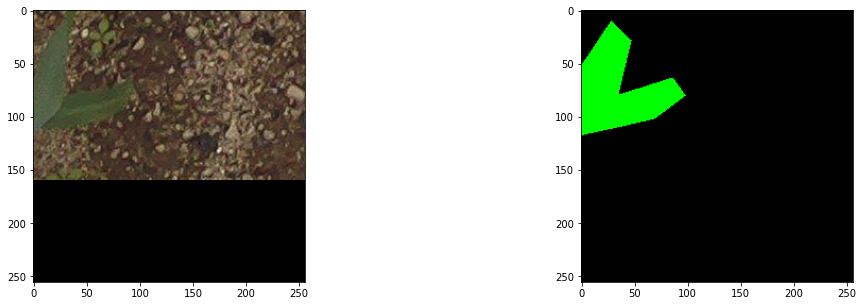

(256, 256, 1)
[0]


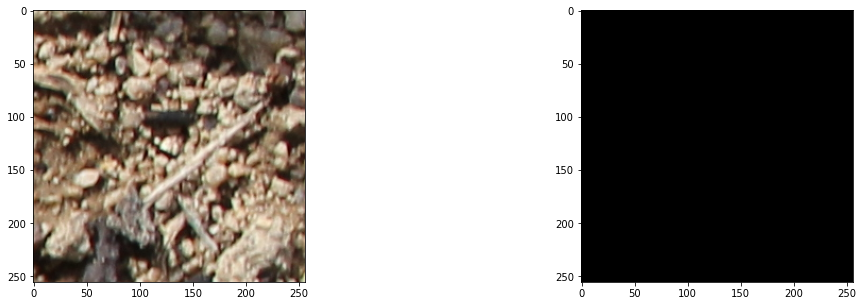

In [14]:
import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline

for k in range(2):
  # plot
  fig, ax = plt.subplots(1, 2)
  fig.set_size_inches(18, 5, forward=True)
  
  idx = np.random.randint(0, len(x_train))
  augmented_img = x_train[idx]
  target = y_train[idx]

  augmented_img = augmented_img * 255  # denormalize

  print(target.shape)

  target_img = np.zeros([target.shape[0], target.shape[1], 3])
  target = tf.squeeze(target, axis=-1)
  #target = np.array(target).flatten()

  print(np.unique(target))


  target_img[np.where(target == 0)] = [0, 0, 0]
  target_img[np.where(target == 1)] = [0, 255, 0] 
  target_img[np.where(target == 2)] = [255, 0, 0] 

  ax[0].imshow(np.uint8(augmented_img))
  ax[1].imshow(np.uint8(target_img))

  plt.show()

In [ ]:

ext = keras.applications.ResNet50V2(input_shape=[target_h, target_w, 3], include_top=False)
for l in ext.layers[:int(len(ext.layers) * 0.95)]:
    l.trainable = False

#search maxpoolings
attach = []
i = 0
for l in ext.layers:
    if isinstance(l, keras.layers.MaxPool2D):
        attach.append(i - 1) # attach to layers before maxpool

    i += 1
attach.sort(reverse=True)

#print(attach)

def up_block(skip_conn, prev, conv_sz):
    prev = keras.layers.UpSampling2D()(prev)
    skip_conn = keras.layers.experimental.preprocessing.Resizing(height = prev.shape[1], width = prev.shape[2], interpolation='nearest')(skip_conn)
    prev = keras.layers.Concatenate(axis=-1)([skip_conn, prev])
    prev = keras.layers.Conv2D(conv_sz,3, activation = 'relu', padding = 'same')(prev)
    prev = keras.layers.Conv2D(conv_sz,3, activation = 'relu', padding = 'same')(prev)
    return prev

last = ext.layers[-1].output
conv_size = 256
for pos in attach:
    last = up_block(ext.layers[pos].output, last, conv_size)
    conv_size /= 2

# add upsample for first big conv
last = up_block(ext.layers[1].output, last, conv_size/2)

last = keras.layers.Conv2D(16, 3, activation = 'relu', padding = 'same')(last)
last = keras.layers.Conv2D(16, 3, activation = 'relu', padding = 'same')(last)

#last = keras.layers.Conv2D(8, 3, activation = 'relu', padding = 'same')(last)

last = keras.layers.Conv2D(num_classes, 1, activation = 'softmax')(last)

model = keras.Model(ext.input, last)
model.summary()


In [ ]:

learning_rate = 1e-5


def meanIoU(y_true, y_pred):
    # get predicted class from softmax
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

    per_class_iou = []

    for i in range(1,3): # exclude the background class 0
      # Get prediction and target related to only a single class (i)
      class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
      class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
      intersection = tf.reduce_sum(class_true * class_pred)
      union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
      iou = (intersection + 1e-7) / (union + 1e-7)
      per_class_iou.append(iou)

    return tf.reduce_mean(per_class_iou)


# compole model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss=keras.losses.SparseCategoricalCrossentropy(), 
    metrics=[meanIoU] 
    )

In [ ]:
from datetime import datetime

now = datetime.now().strftime('%b%d_%H-%M-%S')

#checkpoint_dir = checkpoint_dir+str(now)

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# setup callbacks
# -----------------------

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath=os.path.join(checkpoint_dir, 'cp_{epoch:02d}.ckpt'), save_best_only=True, monitor='val_loss'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
]


In [ ]:
batch_size = 2
epochs = 1

history = model.fit(
          x=x_train,
          y=y_train,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(x_valid, y_valid),
          callbacks=callbacks
          )

In [ ]:
# plot alla metrics 
idx = 1
mtr = ['loss','meanIoU']

plt.figure(figsize=(25, 8))

for m in mtr:
    x = history.history[m]
    val_x = history.history['val_' + m]

    plt.subplot(1, len(mtr), idx)
    plt.plot(x, label='Training ' + m)
    plt.plot(val_x, label='Validation ' + m)
    plt.legend(loc='lower right')
    plt.title('Training and Validation ' + m)
    idx += 1

plt.show()

In [ ]:
def rle_encode(img):
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# return {rle crop prediction, rle weed prediction} img shape
def make_prediction(model, image):

    #print("Original size: "+ str(image.size))

    #img = image.resize([target_w, target_h]) # resize to the network expected size and keep a copy of the original img
    #img = np.array(img) / 255. # rescale
    tiles = tile(np.array(image), target_w)
    predictions = []
    for t in tiles:
        img = tf.expand_dims(t, 0) # add "batch" dimension

        out = model(img, training=False) # predict

        out = tf.squeeze(out, 0) # remove batch dimension to get a 3d vector
        # we got a 3d vector with 3 deph and we need to rescale it to original input size
        # so we denormalize if (output of softmax is 0 < val < 1)
        # and we treat it as img to resize in plt
        out = Image.fromarray(np.uint8(out * 255.)).resize(image.size)
        #print("Predictions:" + str(out.size))
        out = np.array(out)
        # rescale and resize should preserve the old max channels
        # so we can ignore the rescaling to 0-1 again
        out = tf.math.argmax(out, axis=-1) 

        predictions.append(out)

    out = untile(predictions, target_w, image.size)
    

    return out, image.size

# create function to evaluate the model and output results in requeisted format
def output_predictions(model, test_dir):
    submission_dict = {}
    #print(test_dir)

    # iterate all datasets keeping name
    for team in os.listdir(test_dir): #team == dataset name
        team_dir = os.path.join(test_dir, team)

        # iterate all corps for a dataset keeping name
        for crop in os.listdir(team_dir):
            crop_dict = {}
            img_dir = os.path.join(team_dir, crop)
            img_dir = os.path.join(img_dir, "Images")
            # iterate all images 
            files = os.listdir(img_dir)
            i = 0
            for fl in files:
                #print("img: "+ fl)
                # get prediction from model
                image = Image.open(os.path.join(img_dir, fl))
                prediction, shape = make_prediction(model, image)
                
                prediction = np.array(prediction)

                filename, file_extension = os.path.splitext(fl)
                # prepare output dict
                submission_dict[filename] = {
                    'shape': shape,
                    'team': team,
                    'crop': crop,
                    'segmentation': {'crop': rle_encode(prediction == 1), 'weed':rle_encode(prediction == 2)}
                }

                i += 1
                printProgressBar(i, len(files), prefix="Prediction", suffix=team+" - "+crop)
            # end for fl
        # end for crop
    #end for team

    return submission_dict
    


In [ ]:
# plot result of a validation image to understand if net is learning right
samples = 3

for i in range(samples):
    idx = np.random.randint(0, len(x_valid))
    img = x_valid[idx]
    mask = y_valid[idx]

    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(18, 5, forward=True)

    img = np.array(img) * 255
    i = Image.fromarray(np.uint8(img))
    out, shape = make_prediction(model, i)

    # expected mask

    target_img = np.zeros([target.shape[0], target.shape[1], 3])
    target = tf.squeeze(mask, axis=-1)

    target_img[np.where(target == 0)] = [0, 0, 0]
    target_img[np.where(target == 1)] = [0, 255, 0] 
    target_img[np.where(target == 2)] = [255, 0, 0] 

    #prediction
    out_img = np.zeros([out.shape[0], out.shape[1], 3])

    out_img[np.where(out == 0)] = [0, 0, 0]
    out_img[np.where(out == 1)] = [0, 255, 0] 
    out_img[np.where(out == 2)] = [255, 0, 0] 

    ax[0].imshow(np.uint8(img))
    ax[1].imshow(np.uint8(target_img))
    ax[2].imshow(np.uint8(out_img))

    plt.show()


In [ ]:
import json

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# output last model
print("Making prediction with latest model...")
loss, metrics = model.evaluate(x=x_valid, y=y_valid, verbose=2, steps=len(x_valid))

iou = "{:5.2f}".format(100 * metrics)
loss = "{:5.2f}".format(loss)

print("Last model expected results: loss:{}, iou: {}%".format(loss, iou))
res = output_predictions(model, test_dir)

name = '0latest_iou' + iou + '_loss' + loss +'.json'
with open(os.path.join(output_dir, name), 'w') as fp:
        json.dump(res, fp)

print("Done")

In [ ]:
! ls /kaggle/temp/checkpoints

In [ ]:
#ignore this cell if not required
exit()

import json

# predict with checkpoint models
print("Making prediction with best models, this may take a while...")

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

num = 0
ckps = os.listdir(checkpoint_dir)
ckps = ['cp_07.ckpt']

for cp in ckps:
    path_to_model = os.path.join(checkpoint_dir, cp)
    m2 = tf.keras.models.load_model(path_to_model, custom_objects={'meanIoU':meanIoU})
    

    loss, metrics = m2.evaluate(x=x_valid, y=y_valid, verbose=2, steps=len(valid))

    #acc = "{:5.2f}".format(100 * metrics)
    iou = "{:5.2f}".format(100 * metrics)
    loss = "{:5.2f}".format(loss)

    print("Model expected results: loss:{}, iou: {}%".format(loss, iou))
    res = output_predictions(model, test_dir, use_crop)

    # write to file
   
    name = 'iou' + iou + '_loss' + loss +'.json'
    with open(os.path.join(output_dir, name), 'w') as fp:
        json.dump(res, fp)

    num += 1
    print("Progress: "+str(num)+"/"+str(len(ckps)))

print("Done")